# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, recall_score, precision_score, roc_curve, roc_auc_score, plot_confusion_matrix
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('ignore')

import time
from tqdm import tqdm

### Исследовательский анализ данных

Загрузим данные и ознакомимся со структурой датафрейма.

In [2]:
data = pd.read_csv('/datasets/Churn.csv')
display(data.head())

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [3]:
display(data.shape)
display(data.info())

(10000, 14)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


None

Приведем названия столбцов к низкому и змеиному регистру для удобства обращения

In [4]:
data.columns = data.columns.str.lower()

data = data.rename(columns={'rownumber':'row_number', 'customerid':'customer_id', 'creditscore':'credit_score',
                           'numofproducts':'num_of_products', 'hascrcard':'has_cr_card', 'isactivemember':'is_active_member',
                           'estimatedsalary':'estimated_salary'})
display(data.head(3))

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1


Посмотрим на количество дубликатов и пропусков.

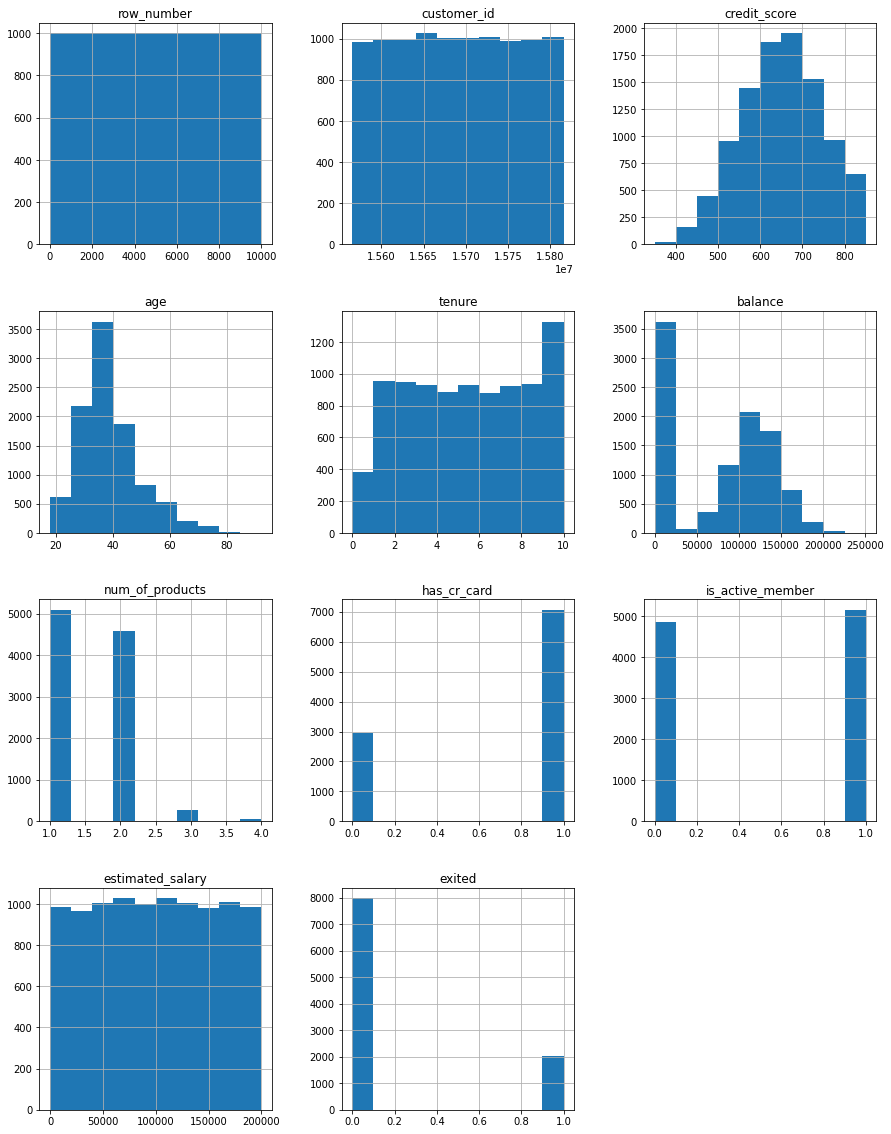

In [5]:
data.hist(figsize=(15, 20))
plt.show()

In [6]:
display(data.duplicated().sum())


0

Явных дубликатов нет, проверим на неявные.

In [7]:
display(data.duplicated(subset=['surname', 'geography', 'age'], keep=False).sum())
display(data[data[['surname', 'geography', 'age']].duplicated() == True])

864

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
341,342,15786170,Tien,659,France,Male,31,NaN,118342.26,1,0,0,161574.19,0
798,799,15570134,Padovano,683,France,Female,35,6.0,187530.66,2,1,1,37976.36,0
804,805,15640280,Cameron,850,France,Male,39,4.0,127771.35,2,0,1,151738.54,0
927,928,15633461,Pai,639,Germany,Male,38,5.0,130170.82,1,1,1,149599.62,0
1264,1265,15732199,Gether,837,Spain,Male,31,9.0,104678.62,1,0,1,50972.60,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9963,9964,15814664,Scott,740,Germany,Male,33,2.0,126524.11,1,1,0,136869.31,0
9966,9967,15590213,Ch'en,479,Spain,Male,35,4.0,125920.98,1,1,1,20393.44,0
9968,9969,15733491,McGregor,512,Germany,Female,40,8.0,153537.57,2,0,0,23101.13,0
9976,9977,15656062,Azikiwe,637,France,Female,33,7.0,103377.81,1,1,0,84419.78,0


Дубликатов по фамилии, географии и возрасту мы видим довольно много, вероятнее всего от того, что такие данные имеют свойство повторяться. Посмотрим, на количество уникальных данных в столбцах balance и estimated_salary, чтобы выбрать какой из них добавить к сравнению, которое поможет нам определить, действительно ли выбранные 864 значения дубликаты, или просто тезки-ровесники

In [8]:
display(data['balance'].value_counts())

0.00         3617
105473.74       2
130170.82       2
72594.00        1
139723.90       1
             ... 
130306.49       1
92895.56        1
132005.77       1
166287.85       1
104001.38       1
Name: balance, Length: 6382, dtype: int64

Здесь мы видим, что баланс может быть одинаков у разных клиентов, потому что он равен нулю.

In [9]:
display(data['estimated_salary'].value_counts())

24924.92     2
109145.20    1
59755.14     1
1557.82      1
117202.19    1
            ..
37674.47     1
158043.11    1
103792.53    1
182266.01    1
155061.97    1
Name: estimated_salary, Length: 9999, dtype: int64

В то время как ожидаемый уровень заработка почти всегда разный. Добавим этот столбец к сравнению, чтобы проверить неявные дубликаты

In [10]:
display(data.duplicated(subset=['surname', 'geography', 'age', 'estimated_salary'], keep=False).sum())
display(data[data[['surname', 'geography', 'estimated_salary']].duplicated() == True])

0

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited


Неявных дубликатов не обнаружено.

In [11]:
data['geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: geography, dtype: int64

Теперь перейдем к пропускам.

In [12]:
display(data.isna().sum())

row_number            0
customer_id           0
surname               0
credit_score          0
geography             0
gender                0
age                   0
tenure              909
balance               0
num_of_products       0
has_cr_card           0
is_active_member      0
estimated_salary      0
exited                0
dtype: int64

In [13]:
display(data['tenure'].describe())
display(data['tenure'].unique())
display(data['tenure'].median())

count    9091.000000
mean        4.997690
std         2.894723
min         0.000000
25%         2.000000
50%         5.000000
75%         7.000000
max        10.000000
Name: tenure, dtype: float64

array([ 2.,  1.,  8.,  7.,  4.,  6.,  3., 10.,  5.,  9.,  0., nan])

5.0

Поскольку в столбце tenure значительное количество пропусков, слишком большое для того, чтобы их игнорировать или удалить, заполним пропуски медианным значением.

In [15]:
data['tenure'] = data['tenure'].fillna(-1)
display(data['tenure'].unique())

array([ 2.,  1.,  8.,  7.,  4.,  6.,  3., 10.,  5.,  9.,  0., -1.])

In [16]:
data['tenure'] = data['tenure'].astype('object')
data.dtypes

row_number            int64
customer_id           int64
surname              object
credit_score          int64
geography            object
gender               object
age                   int64
tenure               object
balance             float64
num_of_products       int64
has_cr_card           int64
is_active_member      int64
estimated_salary    float64
exited                int64
dtype: object

In [17]:
display(data['tenure'].describe())
display(data['tenure'].isna().sum())

count     10000.0
unique       12.0
top           1.0
freq        952.0
Name: tenure, dtype: float64

0

In [18]:
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm')

,row_number,customer_id,credit_score,age,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
row_number,1.000000,0.004202,0.005840,0.000783,-0.009067,0.007246,0.000599,0.012044,-0.005988,-0.016571
customer_id,0.004202,1.000000,0.005308,0.009497,-0.012419,0.016972,-0.014025,0.001665,0.015271,-0.006248
credit_score,0.005840,0.005308,1.000000,-0.003965,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094
age,0.000783,0.009497,-0.003965,1.000000,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323
balance,-0.009067,-0.012419,0.006268,0.028308,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533
num_of_products,0.007246,0.016972,0.012238,-0.030680,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820
has_cr_card,0.000599,-0.014025,-0.005458,-0.011721,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138
is_active_member,0.012044,0.001665,0.025651,0.085472,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128
estimated_salary,-0.005988,0.015271,-0.001384,-0.007201,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097
exited,-0.016571,-0.006248,-0.027094,0.285323,0.118533,-0.047820,-0.007138,-0.156128,0.012097,1.000000


В данных не прослеживается значительной корреляции. Кроме того датасет имеет три столбца, которые не информативны при обучении модели: row_number, customer_id, surname. Удалим эти столбцы.

In [19]:
data = data.drop(['row_number', 'customer_id', 'surname'], axis=1)

In [20]:
display(data.info())
display(data.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      10000 non-null  int64  
 1   geography         10000 non-null  object 
 2   gender            10000 non-null  object 
 3   age               10000 non-null  int64  
 4   tenure            10000 non-null  object 
 5   balance           10000 non-null  float64
 6   num_of_products   10000 non-null  int64  
 7   has_cr_card       10000 non-null  int64  
 8   is_active_member  10000 non-null  int64  
 9   estimated_salary  10000 non-null  float64
 10  exited            10000 non-null  int64  
dtypes: float64(2), int64(6), object(3)
memory usage: 859.5+ KB


None

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


В результате предобработки данных не выявлено явных или неявных дубликатов, пропуски в столбце tenure обработаны и заполнены медианным значением столбца. Значимой корреляции между признаками не обнаружено. Удалены столбцы roe_numeber, customer_id, surname.

Подготовим признаки для обучения модели и решения поставленных задач.

Данные содержат категориальные признаки geography и gender, преобразуем их в численные методом прямого кодирования.

In [21]:
data_ohe = pd.get_dummies(data, drop_first=False)
display(data_ohe.head(5))
display(data_ohe.info())

,credit_score,age,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_France,geography_Germany,...,tenure_1.0,tenure_2.0,tenure_3.0,tenure_4.0,tenure_5.0,tenure_6.0,tenure_7.0,tenure_8.0,tenure_9.0,tenure_10.0
0,619,42,0.00,1,1,1,101348.88,1,1,0,...,0,1,0,0,0,0,0,0,0,0
1,608,41,83807.86,1,0,1,112542.58,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,502,42,159660.80,3,1,0,113931.57,1,1,0,...,0,0,0,0,0,0,0,1,0,0
3,699,39,0.00,2,0,0,93826.63,0,1,0,...,1,0,0,0,0,0,0,0,0,0
4,850,43,125510.82,1,1,1,79084.10,0,0,0,...,0,1,0,0,0,0,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit_score       10000 non-null  int64  
 1   age                10000 non-null  int64  
 2   balance            10000 non-null  float64
 3   num_of_products    10000 non-null  int64  
 4   has_cr_card        10000 non-null  int64  
 5   is_active_member   10000 non-null  int64  
 6   estimated_salary   10000 non-null  float64
 7   exited             10000 non-null  int64  
 8   geography_France   10000 non-null  uint8  
 9   geography_Germany  10000 non-null  uint8  
 10  geography_Spain    10000 non-null  uint8  
 11  gender_Female      10000 non-null  uint8  
 12  gender_Male        10000 non-null  uint8  
 13  tenure_-1.0        10000 non-null  uint8  
 14  tenure_0.0         10000 non-null  uint8  
 15  tenure_1.0         10000 non-null  uint8  
 16  tenure_2.0         1000

None

In [22]:
display(data_ohe)

,credit_score,age,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_France,geography_Germany,...,tenure_1.0,tenure_2.0,tenure_3.0,tenure_4.0,tenure_5.0,tenure_6.0,tenure_7.0,tenure_8.0,tenure_9.0,tenure_10.0
0,619,42,0.00,1,1,1,101348.88,1,1,0,...,0,1,0,0,0,0,0,0,0,0
1,608,41,83807.86,1,0,1,112542.58,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,502,42,159660.80,3,1,0,113931.57,1,1,0,...,0,0,0,0,0,0,0,1,0,0
3,699,39,0.00,2,0,0,93826.63,0,1,0,...,1,0,0,0,0,0,0,0,0,0
4,850,43,125510.82,1,1,1,79084.10,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,0.00,2,1,0,96270.64,0,1,0,...,0,0,0,0,1,0,0,0,0,0
9996,516,35,57369.61,1,1,1,101699.77,0,1,0,...,0,0,0,0,0,0,0,0,0,1
9997,709,36,0.00,1,0,1,42085.58,1,1,0,...,0,0,0,0,0,0,1,0,0,0
9998,772,42,75075.31,2,1,0,92888.52,1,0,1,...,0,0,1,0,0,0,0,0,0,0


В нашем случае целевой признак - столбец exited, т.к. именно в нем содержатся данные о том, остался пользователь клиентом банка или нет. Отделим от данных целевой признак и разделим данные на три выборки - обучающую, валидационную и тестовую. Используем параметр stratify для сохранения пропорций исходного набора данных в нашей выборке.

In [23]:
X = data_ohe.drop('exited', axis=1)
y = data_ohe['exited']

In [24]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.4, random_state=12345, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=12345, stratify=y_valid)

In [25]:
print('Размер тренировочной выборки X_train:', X_train.shape[0], 'объектов')
print('Размер валидационной выборки X_valid:', X_valid.shape[0], 'объектов')
print('Размер тестовой выборки X_test:', X_test.shape[0], 'объектов')
print('Размер тренировочной выборки y_train:', y_train.shape[0], 'объектов')
print('Размер валидационной выборки y_valid:', y_valid.shape[0], 'объектов')
print('Размер тестовой выборки y_test:', y_test.shape[0], 'объектов')

Размер тренировочной выборки X_train: 6000 объектов
Размер валидационной выборки X_valid: 2000 объектов
Размер тестовой выборки X_test: 2000 объектов
Размер тренировочной выборки y_train: 6000 объектов
Размер валидационной выборки y_valid: 2000 объектов
Размер тестовой выборки y_test: 2000 объектов


Признаки age, credit_score, balance и estimated_salary имеют большой разброс. Стандартизируем признаки с помощью StandartScaler.

In [26]:
scaler = StandardScaler()
numeric = ['age', 'credit_score', 'balance', 'estimated_salary']
scaler.fit(X_train[numeric])
X_train[numeric] = scaler.transform(X_train[numeric])
X_valid[numeric] = scaler.transform(X_valid[numeric])

### Вывод

Данные предобработаны, категориальные признаки преобразованы в числовые, датасет разбит на три выборки с применением стратификации, проведено масштабирование данных на тренировочной и валидационной выборках.

## Исследование задачи

Для исследования задачи воспользуемся ранее изучеными средствами решения задач классификации:

### **Решающее дерево**

В цикле подберем параметры модели:

In [27]:
best_depth_dtc = 0
f1_dtc = 0
for depth in tqdm(range(2, 20)):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(X_train, y_train)
    predictions = model.predict(X_valid)
    f1_dtc_valid = f1_score(y_valid, predictions)
    if f1_dtc_valid > f1_dtc:
        best_depth_dtc = depth
        f1_dtc = f1_dtc_valid
display(best_depth_dtc)
display(f1_dtc)

100%|██████████| 18/18 [00:00<00:00, 39.81it/s]


7

0.5939741750358679

Проверим метрики качества на модели с наилучшей глубиной обучения.

In [28]:
model = DecisionTreeClassifier(random_state=12345, max_depth=best_depth_dtc)
model.fit(X_train, y_train)
predictions = model.predict(X_valid)
print('F-1 мера:', f1_score(y_valid, predictions))
print('Полнота:', recall_score(y_valid, predictions))
print('Точность:', precision_score(y_valid, predictions))


F-1 мера: 0.5939741750358679
Полнота: 0.5073529411764706
Точность: 0.7162629757785467


Построим ROC-кривую для модели Решающего дерева в сравнении с ROC-кривой случайной модели

In [29]:
probabilities_valid = model.predict_proba(X_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(y_valid, probabilities_one_valid)

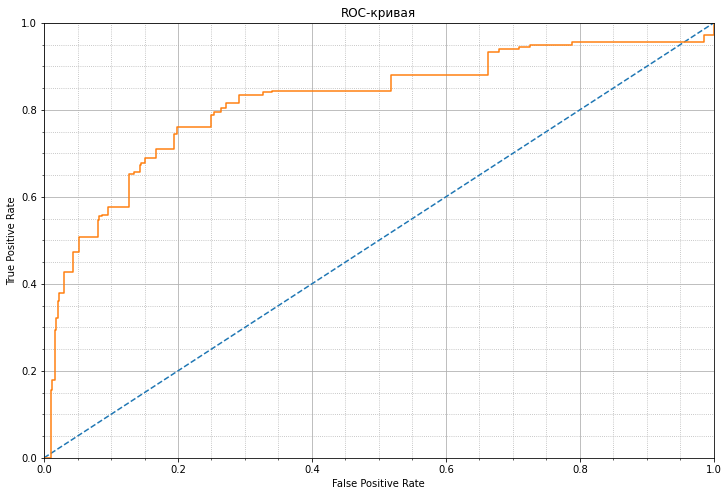

In [30]:
plt.figure(figsize=(12,8))

plt.plot([0, 1], [0, 1], linestyle='--')

plt.step(fpr, tpr, where='post')

plt.minorticks_on()
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

In [31]:
print('Площадь под ROC-кривой:', roc_auc_score(y_valid, probabilities_one_valid))

Площадь под ROC-кривой: 0.8327890986796729


Построим матрицу ошибок

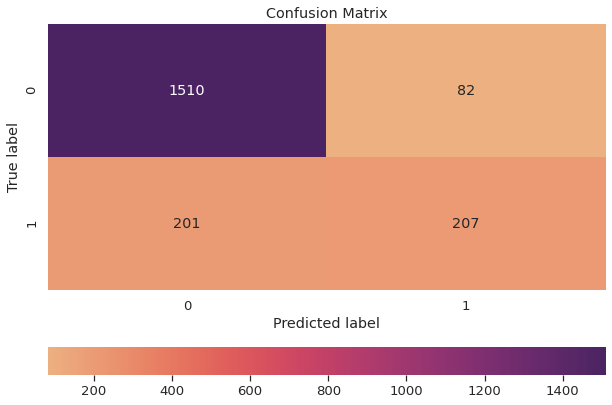

In [32]:
cm = confusion_matrix(y_valid, predictions)

plt.figure(figsize = (10,7))
sns.set(font_scale=1.2)
sns.heatmap(cm, fmt='.5g', cmap='flare', annot=True, cbar_kws= {'orientation': 'horizontal'})
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

Значение F1-меры равно 0,59, площадь под ROC-кривой равна 0,82, полнота равна 0.50, точность 0.72

Посмотрим на частоту встречаемости классов.

0    0.8555
1    0.1445
dtype: float64


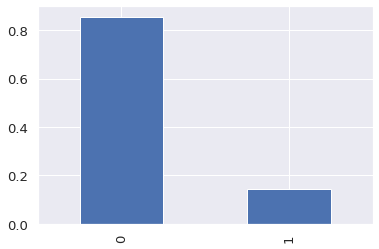

In [33]:
predicted_valid = pd.Series(model.predict(X_valid))

class_frequency = predicted_valid.value_counts(normalize=False)/len(y_valid)
print(class_frequency)
class_frequency.plot(kind='bar')
plt.show()

### **Случайный лес**

Аналогично предыдущей модели подберем лучшие параметры в цикле.

In [34]:
best_depth_rf = 0
best_est_rf = 0
best_f1_rf = 0

for est in tqdm(range(10, 51, 10)):
    for depth in range(3, 20):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(X_train, y_train)
        predictions = model.predict(X_valid)
        f1_valid = f1_score(y_valid, predictions)
        if f1_valid > best_f1_rf:
            best_depth_rf = depth
            best_est_rf = est
            best_f1_rf = f1_valid
        
display(best_depth_rf)
display(best_est_rf)
display(best_f1_rf)


100%|██████████| 5/5 [00:12<00:00,  2.50s/it]


17

20

0.6172106824925816

Проверим модель с лучшими параметрами

In [35]:
model = RandomForestClassifier(random_state=12345, max_depth=best_depth_rf, n_estimators=best_est_rf)
model.fit(X_train, y_train)
predictions = model.predict(X_valid)

print('F-1 мера:', f1_score(y_valid, predictions))
print('Полнота:', recall_score(y_valid, predictions))
print('Точность:', precision_score(y_valid, predictions))

F-1 мера: 0.6172106824925816
Полнота: 0.5098039215686274
Точность: 0.7819548872180451


Построим ROC-кривую для обученной модели в сравнении c ROC-кривой случайной модели

In [36]:
probabilities_valid = model.predict_proba(X_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(y_valid, probabilities_one_valid)

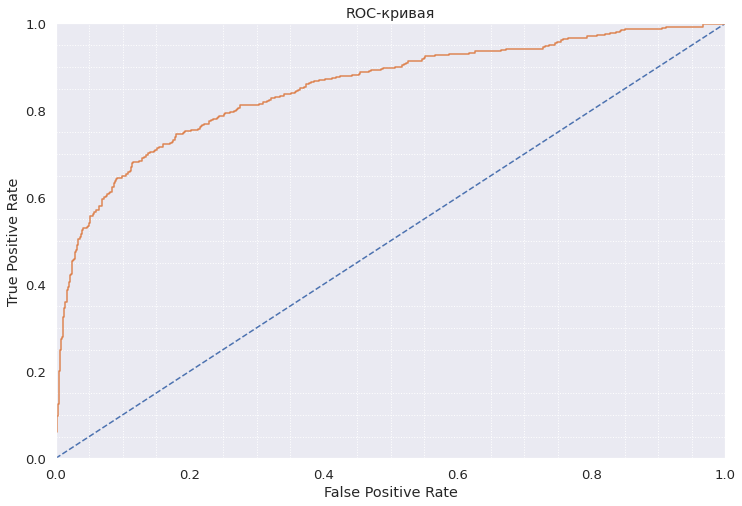

In [37]:
plt.figure(figsize=(12,8))

plt.plot([0, 1], [0, 1], linestyle='--')

plt.step(fpr, tpr, where='post')

plt.minorticks_on()
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

In [38]:
print('Площадь под ROC-кривой:', roc_auc_score(y_valid, probabilities_one_valid))

Площадь под ROC-кривой: 0.850627216967189


Построим матрицу ошибок

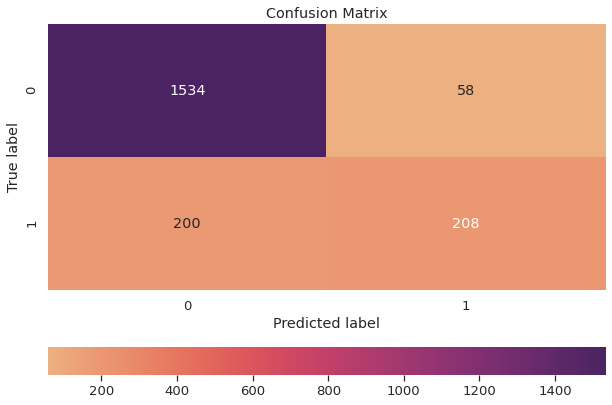

In [39]:
cm = confusion_matrix(y_valid, predictions)

plt.figure(figsize = (10,7))
sns.set(font_scale=1.2)
sns.heatmap(cm, fmt='.5g', cmap='flare', annot=True, cbar_kws= {'orientation': 'horizontal'})
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

F-1 мера равна 0.60, полнота: 0.49, точность: 0.75 относительно модели обученной методом Решающего дерева повысилась точность предсказаний, но уменьшилась полнота.

Частота классов:

0    0.867
1    0.133
dtype: float64


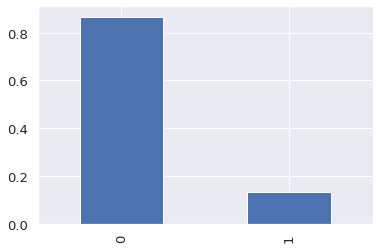

In [40]:
predicted_valid = pd.Series(model.predict(X_valid))

class_frequency = predicted_valid.value_counts(normalize=False)/len(y_valid)
print(class_frequency)
class_frequency.plot(kind='bar')
plt.show()

### **Логистическая регрессия**

Обучим модель

In [41]:
best_iterat_lr = 0
best_f1_lr = 0

for iterat in tqdm(range (1, 50)):
    model = LogisticRegression(random_state=12345, max_iter=iterat, solver='lbfgs')
    model.fit(X_train, y_train)
    predictions = model.predict(X_valid)
    f1_lr = f1_score(y_valid, predictions)
    if f1_lr > best_f1_lr:
        best_iterat_lr = iterat
        best_f1_lr = f1_lr

display(best_iterat_lr)
display(best_f1_lr)
    

100%|██████████| 49/49 [00:19<00:00,  2.52it/s]


12

0.3169398907103825

Обучим модель с лучшими параметрами

In [42]:
model = LogisticRegression(random_state=12345, max_iter=best_iterat_lr, solver='lbfgs')
model.fit(X_train, y_train)
predictions = model.predict(X_valid)

print('F-1 мера:', f1_score(y_valid, predictions))
print('Полнота:', recall_score(y_valid, predictions))
print('Точность:', precision_score(y_valid, predictions))

F-1 мера: 0.3169398907103825
Полнота: 0.21323529411764705
Точность: 0.6170212765957447


Построим ROC-кривую для обученной модели в сравнении с ROC-кривой случайной модели

In [43]:
probabilities_valid = model.predict_proba(X_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(y_valid, probabilities_one_valid)

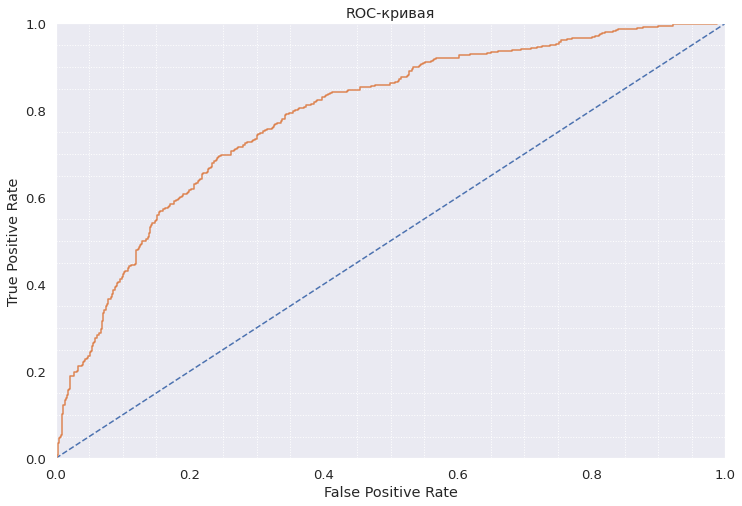

In [44]:
plt.figure(figsize=(12,8))

plt.plot([0, 1], [0, 1], linestyle='--')

plt.step(fpr, tpr, where='post')

plt.minorticks_on()
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

In [45]:
print('Площадь под ROC-кривой:', roc_auc_score(y_valid, probabilities_one_valid))

Площадь под ROC-кривой: 0.787520630111341


Построим матрицу ошибок

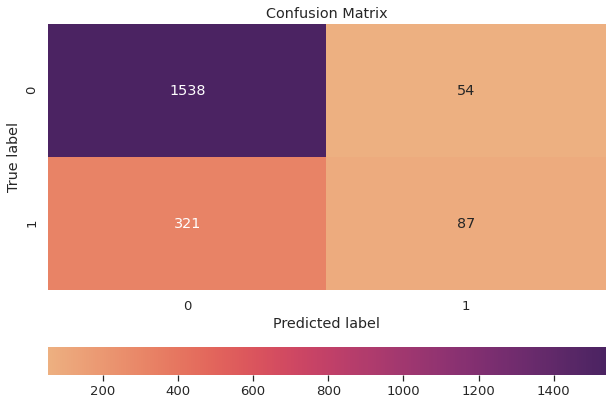

In [46]:
cm = confusion_matrix(y_valid, predictions)

plt.figure(figsize = (10,7))
sns.set(font_scale=1.2)
sns.heatmap(cm, fmt='.5g', cmap='flare', annot=True, cbar_kws= {'orientation': 'horizontal'})
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

Модель обученная методом логистической регресии показала следующие результаты: F-1 мера равна 0.32, полнота равна 0.21, точность 0.63, что не соответствует требованиям исследования.

Частота классов для логистической регрессии

0    0.9295
1    0.0705
dtype: float64


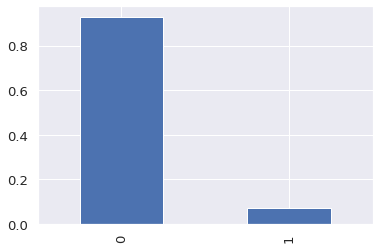

In [47]:
predicted_valid = pd.Series(model.predict(X_valid))

class_frequency = predicted_valid.value_counts(normalize=False)/len(y_valid)
print(class_frequency)
class_frequency.plot(kind='bar')
plt.show()

### Вывод

In [48]:
models = ['DecisionTree', 'RandomForest', 'LogisticRegression']
f1_scores = [f1_dtc, best_f1_rf, best_f1_lr]

best_model = pd.DataFrame({'model':models, 'f1_score':f1_scores})
display(best_model)

,model,f1_score
0,DecisionTree,0.593974
1,RandomForest,0.617211
2,LogisticRegression,0.316940


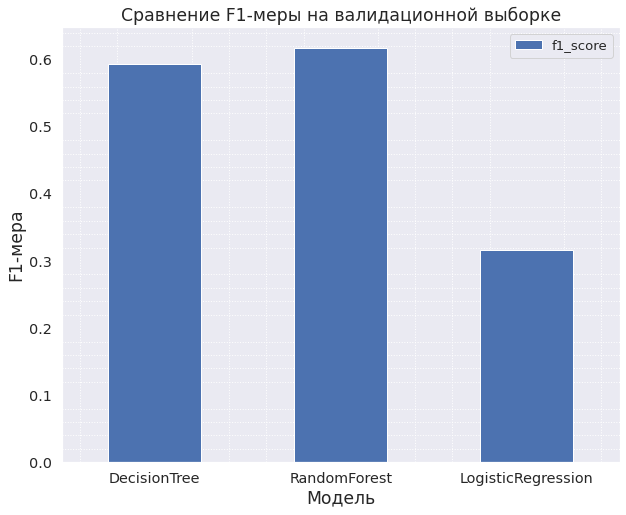

In [50]:
best_model.plot.bar(x='model', figsize=(10,8), fontsize='medium', rot='0')
plt.minorticks_on()
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.title('Сравнение F1-меры на валидационной выборке', fontsize='large')
plt.xlabel('Модель', fontsize='large')
plt.ylabel('F1-мера', fontsize='large')

plt.show()

Проведенное исследование демонстрирует нам отсутсвие баланса классов в целевом признаке, количество действующих клиентов банка значительно превышает количество ушедших.
На не сбалансированных данных самое высокое значение F1-меры демонстирует модель обученная методом "случайный лес", самое низкое - логистической регрессии. Проведем балансирование классов, чтобы узнать насколько получиться улучшить качество моделей.

## Борьба с дисбалансом

Сбалансируем данные с помощью ранее изученных способов.

### **Взвешивание классов**

#### *Решающее дерево*

Обучим модель используя параметр *class_weight='balanced'* для придания меньшему классу большего веса.

In [51]:
best_depth_dtc = 0
f1_dtc = 0
for depth in tqdm(range(2, 20)):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced')
    model.fit(X_train, y_train)
    predictions = model.predict(X_valid)
    f1_dtc_valid = f1_score(y_valid, predictions)
    if f1_dtc_valid > f1_dtc:
        best_depth_dtc = depth
        f1_dtc = f1_dtc_valid
display(best_depth_dtc)
display(f1_dtc)

100%|██████████| 18/18 [00:00<00:00, 37.97it/s]


6

0.5764596848934197

In [52]:
model = DecisionTreeClassifier(random_state=12345, max_depth=best_depth_dtc, class_weight='balanced')
model.fit(X_train, y_train)
predictions = model.predict(X_valid)
print('F-1 мера:', f1_score(y_valid, predictions))
print('Полнота:', recall_score(y_valid, predictions))
print('Точность:', precision_score(y_valid, predictions))

F-1 мера: 0.5764596848934197
Полнота: 0.7622549019607843
Точность: 0.46348733233979134


In [53]:
probabilities_valid = model.predict_proba(X_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(y_valid, probabilities_one_valid)

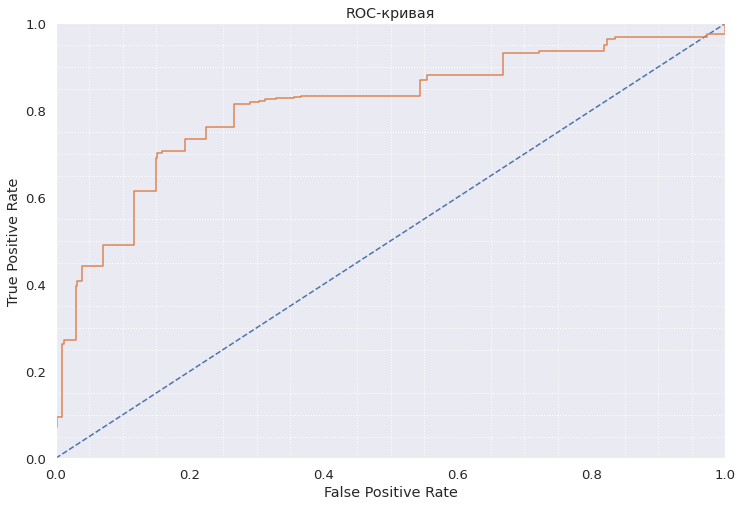

Площадь под ROC-кривой: 0.8253199206818406


In [54]:
plt.figure(figsize=(12,8))

plt.plot([0, 1], [0, 1], linestyle='--')

plt.step(fpr, tpr, where='post')

plt.minorticks_on()
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

print('Площадь под ROC-кривой:', roc_auc_score(y_valid, probabilities_one_valid))

0    0.6645
1    0.3355
dtype: float64


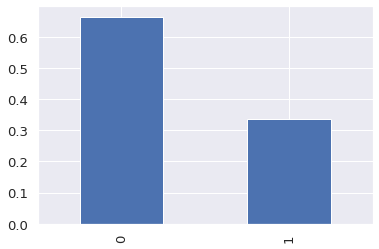

In [55]:
predicted_valid = pd.Series(model.predict(X_valid))

class_frequency = predicted_valid.value_counts(normalize=False)/len(y_valid)
print(class_frequency)
class_frequency.plot(kind='bar')
plt.show()

На представленной визуализации можно увидеть, что вес классов изменился, однако это привело к ухудшению показателей модели.

#### *Случайный лес*

In [56]:
best_depth_rf = 0
best_est_rf = 0
best_f1_rf = 0

for est in tqdm(range(10, 51, 10)):
    for depth in range(3, 20):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth, class_weight='balanced')
        model.fit(X_train, y_train)
        predictions = model.predict(X_valid)
        f1_valid = f1_score(y_valid, predictions)
        if f1_valid > best_f1_rf:
            best_depth_rf = depth
            best_est_rf = est
            best_f1_rf = f1_valid
        
display(best_depth_rf)
display(best_est_rf)
display(best_f1_rf)


100%|██████████| 5/5 [00:13<00:00,  2.68s/it]


10

50

0.6566820276497695

In [57]:
model = RandomForestClassifier(random_state=12345, max_depth=best_depth_rf, n_estimators=best_est_rf, class_weight='balanced')
model.fit(X_train, y_train)
predictions = model.predict(X_valid)

print('F-1 мера:', f1_score(y_valid, predictions))
print('Полнота:', recall_score(y_valid, predictions))
print('Точность:', precision_score(y_valid, predictions))

F-1 мера: 0.6566820276497695
Полнота: 0.6985294117647058
Точность: 0.6195652173913043


In [58]:
probabilities_valid = model.predict_proba(X_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(y_valid, probabilities_one_valid)

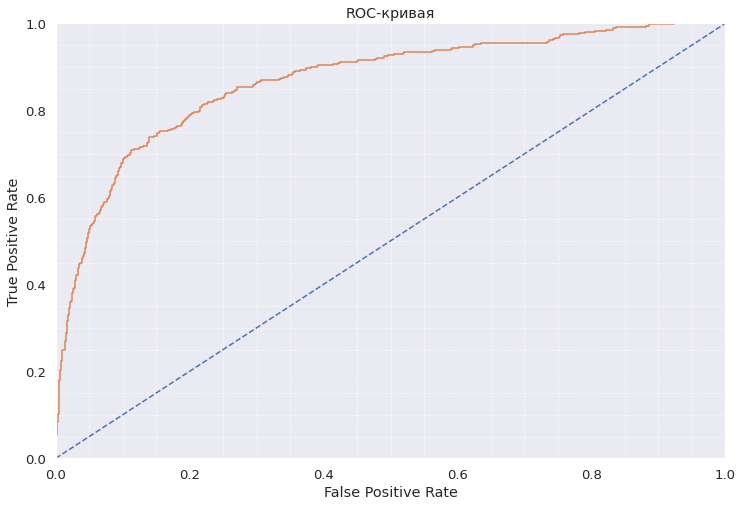

Площадь под ROC-кривой: 0.868218235786777


In [59]:
plt.figure(figsize=(12,8))

plt.plot([0, 1], [0, 1], linestyle='--')

plt.step(fpr, tpr, where='post')

plt.minorticks_on()
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

print('Площадь под ROC-кривой:', roc_auc_score(y_valid, probabilities_one_valid))

0    0.77
1    0.23
dtype: float64


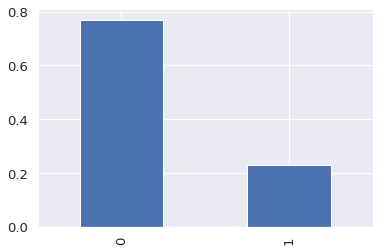

In [60]:
predicted_valid = pd.Series(model.predict(X_valid))

class_frequency = predicted_valid.value_counts(normalize=False)/len(y_valid)
print(class_frequency)
class_frequency.plot(kind='bar')
plt.show()

Частота встречаемости классов после взвешивания изменилась незначительно, однако показатели модели ухудшились

#### *Логистическая регрессия*

In [61]:
best_iterat_lr = 0
best_f1_lr = 0

for iterat in tqdm(range (1, 50)):
    model = LogisticRegression(random_state=12345, max_iter=iterat, solver='lbfgs', class_weight='balanced')
    model.fit(X_train, y_train)
    predictions = model.predict(X_valid)
    f1_lr = f1_score(y_valid, predictions)
    if f1_lr > best_f1_lr:
        best_iterat_lr = iterat
        best_f1_lr = f1_lr

display(best_iterat_lr)
display(best_f1_lr)
    

100%|██████████| 49/49 [00:17<00:00,  2.77it/s]


5

0.5341841385597084

In [62]:
model = LogisticRegression(random_state=12345, max_iter=best_iterat_lr, solver='lbfgs', class_weight='balanced')
model.fit(X_train, y_train)
predictions = model.predict(X_valid)

print('F-1 мера:', f1_score(y_valid, predictions))
print('Полнота:', recall_score(y_valid, predictions))
print('Точность:', precision_score(y_valid, predictions))

F-1 мера: 0.5341841385597084
Полнота: 0.7181372549019608
Точность: 0.42525399129172714


In [63]:
probabilities_valid = model.predict_proba(X_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(y_valid, probabilities_one_valid)

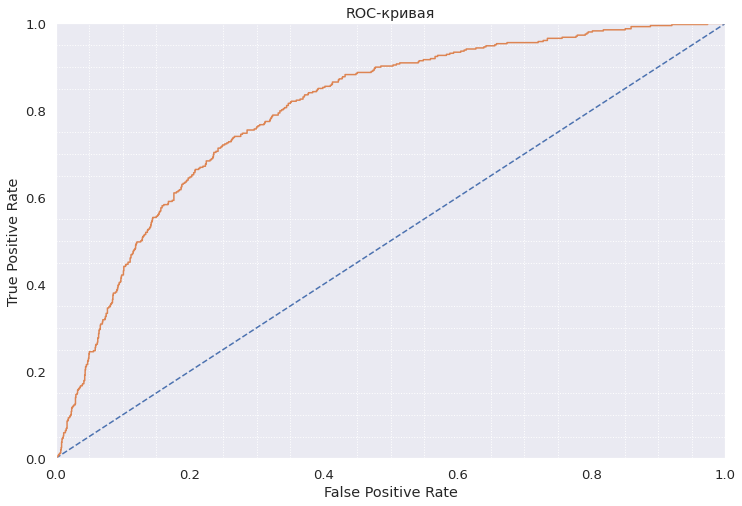

Площадь под ROC-кривой: 0.7987563429894571


In [64]:
plt.figure(figsize=(12,8))

plt.plot([0, 1], [0, 1], linestyle='--')

plt.step(fpr, tpr, where='post')

plt.minorticks_on()
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

print('Площадь под ROC-кривой:', roc_auc_score(y_valid, probabilities_one_valid))

0    0.6555
1    0.3445
dtype: float64


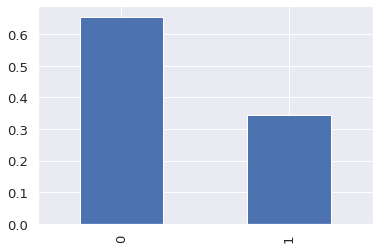

In [65]:
predicted_valid = pd.Series(model.predict(X_valid))

class_frequency = predicted_valid.value_counts(normalize=False)/len(y_valid)
print(class_frequency)
class_frequency.plot(kind='bar')
plt.show()

Для модели обученной методом логистической регрессии f1-мера и полнота, в то время как точность снизилась. Частота встречаемости классов изменилась в большую сторону, незначительно увеличилась площадь под ROC-кривой.

### **Увеличение выборки**

In [66]:
def upsample(X, y, repeat):
    X_zeros = X[y == 0]
    X_ones = X[y == 1]
    y_zeros = y[y == 0]
    y_ones = y[y == 1]

    X_upsampled = pd.concat([X_zeros] + [X_ones] * repeat)
    y_upsampled = pd.concat([y_zeros] + [y_ones] * repeat)
    
    X_upsampled, y_upsampled = shuffle(
        X_upsampled, y_upsampled, random_state=12345)
    
    return X_upsampled, y_upsampled



In [67]:
X_upsampled, y_upsampled = upsample(X_train, y_train, 4)

1    0.4888
0    0.4778
Name: exited, dtype: float64


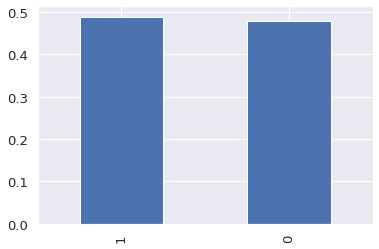

In [68]:
class_frequency = (y_upsampled.value_counts(normalize=False))/len(data)
print(class_frequency)
class_frequency.plot(kind='bar')
plt.show()

#### *Решающее дерево*

In [69]:
best_depth_dtc = 0
f1_dtc = 0
for depth in tqdm(range(2, 20)):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(X_upsampled, y_upsampled)
    predictions = model.predict(X_valid)
    f1_dtc_valid = f1_score(y_valid, predictions)
    if f1_dtc_valid > f1_dtc:
        best_depth_dtc = depth
        f1_dtc = f1_dtc_valid
display(best_depth_dtc)
display(f1_dtc)

100%|██████████| 18/18 [00:00<00:00, 18.02it/s]


6

0.5785582255083179

In [70]:
model = DecisionTreeClassifier(random_state=12345, max_depth=best_depth_dtc)
model.fit(X_upsampled, y_upsampled)
predictions = model.predict(X_valid)
print('F-1 мера:', f1_score(y_valid, predictions))
print('Полнота:', recall_score(y_valid, predictions))
print('Точность:', precision_score(y_valid, predictions))

F-1 мера: 0.5785582255083179
Полнота: 0.7671568627450981
Точность: 0.46439169139465875


In [71]:
probabilities_valid = model.predict_proba(X_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(y_valid, probabilities_one_valid)

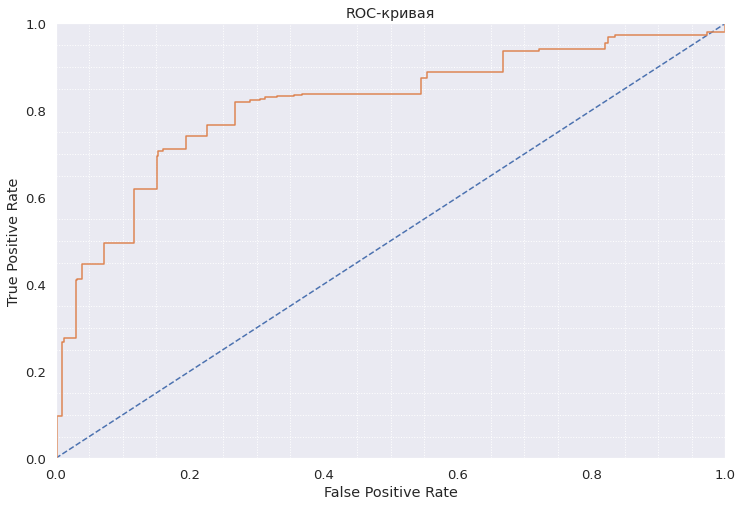

Площадь под ROC-кривой: 0.829526000098532


In [72]:
plt.figure(figsize=(12,8))

plt.plot([0, 1], [0, 1], linestyle='--')

plt.step(fpr, tpr, where='post')

plt.minorticks_on()
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

print('Площадь под ROC-кривой:', roc_auc_score(y_valid, probabilities_one_valid))

На увеличенной выборке у решающего дерева увеличились F1-мера и полнота, точность при этом уменьшилась, а площадь под ROC-кривой осталась практически без изменений

#### *Случайный лес*

In [73]:
best_depth_rf = 0
best_est_rf = 0
best_f1_rf = 0

for est in tqdm(range(10, 51, 10)):
    for depth in range(3, 20):
        model = RandomForestClassifier(random_state=12345, n_estimators=est)
        model.fit(X_upsampled, y_upsampled)
        predictions = model.predict(X_valid)
        f1_valid = f1_score(y_valid, predictions)
        if f1_valid > best_f1_rf:
            best_depth_rf = depth
            best_est_rf = est
            best_f1_rf = f1_valid
        
display(best_depth_rf)
display(best_est_rf)
display(best_f1_rf)

100%|██████████| 5/5 [00:23<00:00,  4.76s/it]


3

50

0.6184738955823292

In [74]:
model = RandomForestClassifier(random_state=12345, max_depth=best_depth_rf, n_estimators=best_est_rf)
model.fit(X_upsampled, y_upsampled)
predictions = model.predict(X_valid)

print('F-1 мера:', f1_score(y_valid, predictions))
print('Полнота:', recall_score(y_valid, predictions))
print('Точность:', precision_score(y_valid, predictions))

F-1 мера: 0.5854092526690392
Полнота: 0.8063725490196079
Точность: 0.4594972067039106


In [75]:
probabilities_valid = model.predict_proba(X_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(y_valid, probabilities_one_valid)

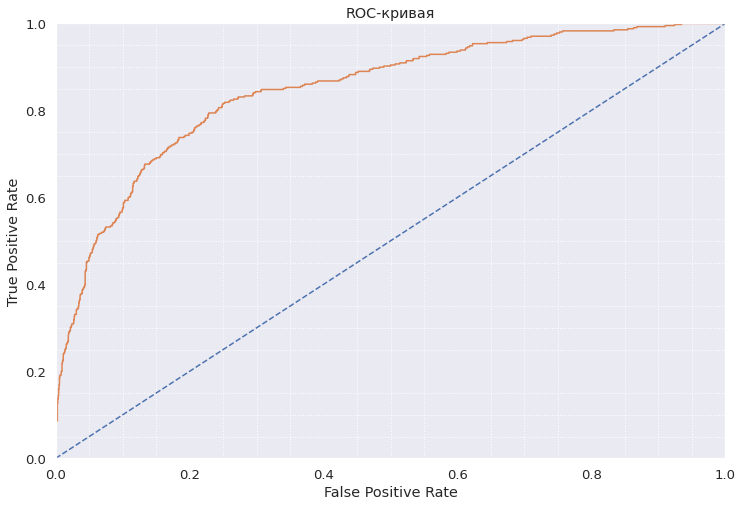

Площадь под ROC-кривой: 0.84740183761947


In [76]:
plt.figure(figsize=(12,8))

plt.plot([0, 1], [0, 1], linestyle='--')

plt.step(fpr, tpr, where='post')

plt.minorticks_on()
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

print('Площадь под ROC-кривой:', roc_auc_score(y_valid, probabilities_one_valid))

У модели обученной методом случайного леса метрики f1 и полнота улучшились, относительно модели обученной методом случайного леса, после взвешивания классов, в то время как точность снизилась. Площадь под ROC-кривой - без динамики.

#### *Логистическая регрессия*

In [77]:
best_iterat_lr = 0
best_f1_lr = 0

for iterat in tqdm(range (1, 50)):
    model = LogisticRegression(random_state=12345, max_iter=iterat, solver='lbfgs')
    model.fit(X_upsampled, y_upsampled)
    predictions = model.predict(X_valid)
    f1_lr = f1_score(y_valid, predictions)
    if f1_lr > best_f1_lr:
        best_iterat_lr = iterat
        best_f1_lr = f1_lr

display(best_iterat_lr)
display(best_f1_lr)

100%|██████████| 49/49 [00:39<00:00,  1.25it/s]


3

0.5335753176043557

In [78]:
model = LogisticRegression(random_state=12345, max_iter=best_iterat_lr, solver='lbfgs')
model.fit(X_upsampled, y_upsampled)
predictions = model.predict(X_valid)

print('F-1 мера:', f1_score(y_valid, predictions))
print('Полнота:', recall_score(y_valid, predictions))
print('Точность:', precision_score(y_valid, predictions))

F-1 мера: 0.5335753176043557
Полнота: 0.7205882352941176
Точность: 0.42363112391930835


In [79]:
probabilities_valid = model.predict_proba(X_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(y_valid, probabilities_one_valid)

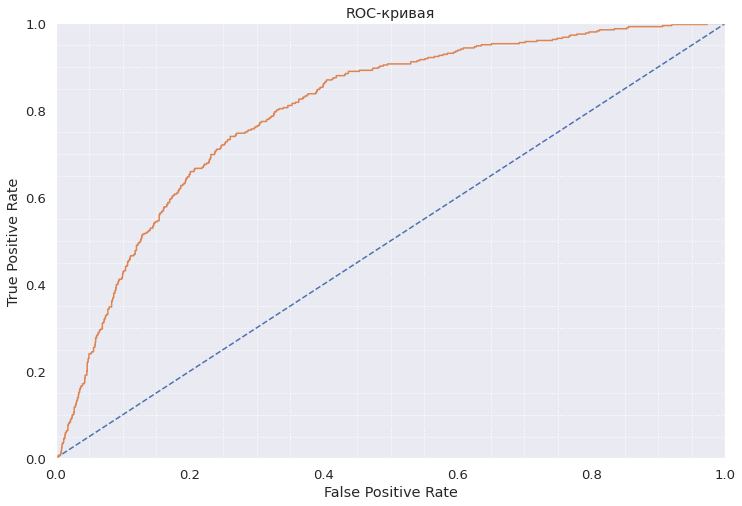

Площадь под ROC-кривой: 0.7994044979800966


In [80]:
plt.figure(figsize=(12,8))

plt.plot([0, 1], [0, 1], linestyle='--')

plt.step(fpr, tpr, where='post')

plt.minorticks_on()
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

print('Площадь под ROC-кривой:', roc_auc_score(y_valid, probabilities_one_valid))

Для модели обученной методом логистической регрессии так же можно отметить увеличение F1-меры и полноты, при снижении точности и стабильности площади под ROC-кривой.

### **Уменьшение выборки**

In [81]:
def downsample(X, y, fraction):
    X_zeros = X[y == 0]
    X_ones = X[y == 1]
    y_zeros = y[y == 0]
    y_ones = y[y == 1]
    
    X_downsampled = pd.concat([X_zeros.sample(frac=fraction, random_state=12345)] + [X_ones])
    y_downsampled = pd.concat([y_zeros.sample(frac=fraction, random_state=12345)] + [y_ones])
    
    X_downsampled, y_downsampled = shuffle(
        X_downsampled, y_downsampled, random_state=12345)
    
    return X_downsampled, y_downsampled

X_downsampled, y_downsampled = downsample(X_train, y_train, 0.25)

#### *Решающее дерево*

In [82]:
best_depth_dtc = 0
f1_dtc = 0
for depth in tqdm(range(2, 20)):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(X_downsampled, y_downsampled)
    predictions = model.predict(X_valid)
    f1_dtc_valid = f1_score(y_valid, predictions)
    if f1_dtc_valid > f1_dtc:
        best_depth_dtc = depth
        f1_dtc = f1_dtc_valid
display(best_depth_dtc)
display(f1_dtc)

100%|██████████| 18/18 [00:00<00:00, 73.49it/s]


6

0.5977229601518027

In [83]:
model = DecisionTreeClassifier(random_state=12345, max_depth=best_depth_dtc)
model.fit(X_downsampled, y_downsampled)
predictions = model.predict(X_valid)
print('F-1 мера:', f1_score(y_valid, predictions))
print('Полнота:', recall_score(y_valid, predictions))
print('Точность:', precision_score(y_valid, predictions))

F-1 мера: 0.5977229601518027
Полнота: 0.7720588235294118
Точность: 0.48761609907120745


In [84]:
probabilities_valid = model.predict_proba(X_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(y_valid, probabilities_one_valid)

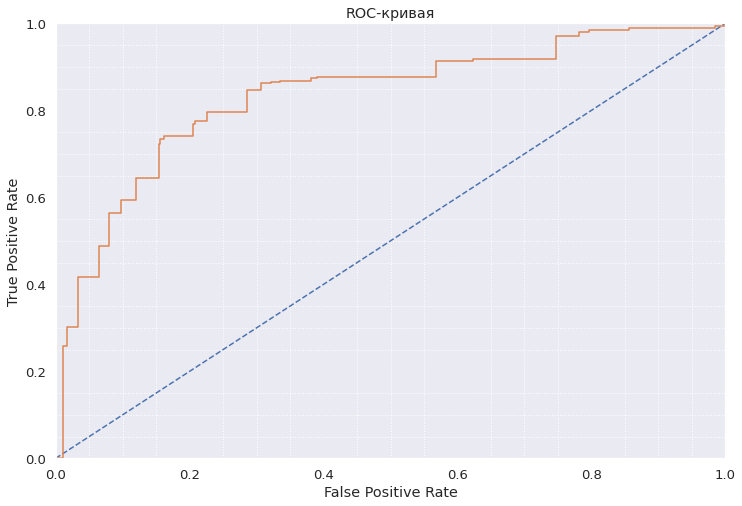

Площадь под ROC-кривой: 0.8499690548329883


In [85]:
plt.figure(figsize=(12,8))

plt.plot([0, 1], [0, 1], linestyle='--')

plt.step(fpr, tpr, where='post')

plt.minorticks_on()
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

print('Площадь под ROC-кривой:', roc_auc_score(y_valid, probabilities_one_valid))

Для решающего дерева увеличились f1-мера и точность, но снизилась полнота. Так же увеличилась площадь под ROC-кривой.

#### *Случайный лес*

In [86]:
best_depth_rf = 0
best_est_rf = 0
best_f1_rf = 0

for est in tqdm(range(10, 51, 10)):
    for depth in range(3, 20):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(X_train, y_train)
        predictions = model.predict(X_valid)
        f1_valid = f1_score(y_valid, predictions)
        if f1_valid > best_f1_rf:
            best_depth_rf = depth
            best_est_rf = est
            best_f1_rf = f1_valid
        
display(best_depth_rf)
display(best_est_rf)
display(best_f1_rf)

100%|██████████| 5/5 [00:13<00:00,  2.66s/it]


17

20

0.6172106824925816

In [87]:
model = RandomForestClassifier(random_state=12345, max_depth=best_depth_rf, n_estimators=best_est_rf)
model.fit(X_downsampled, y_downsampled)
predictions = model.predict(X_valid)

print('F-1 мера:', f1_score(y_valid, predictions))
print('Полнота:', recall_score(y_valid, predictions))
print('Точность:', precision_score(y_valid, predictions))

F-1 мера: 0.584729981378026
Полнота: 0.7696078431372549
Точность: 0.47147147147147145


In [88]:
probabilities_valid = model.predict_proba(X_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(y_valid, probabilities_one_valid)

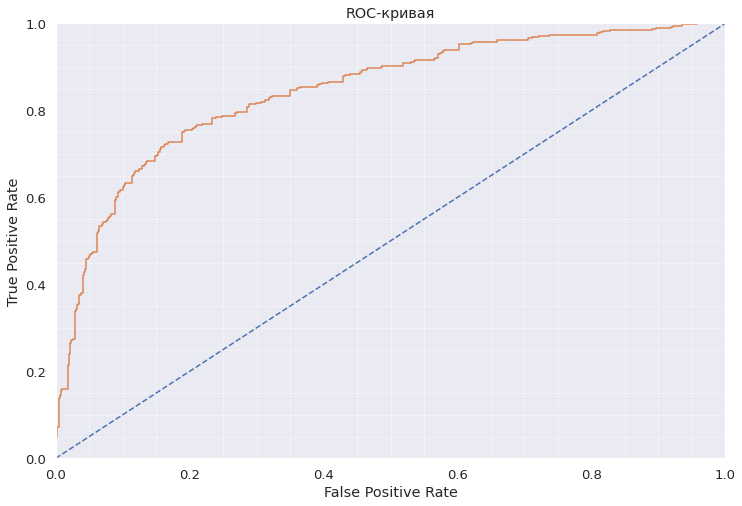

Площадь под ROC-кривой: 0.8456290336486353


In [89]:
plt.figure(figsize=(12,8))

plt.plot([0, 1], [0, 1], linestyle='--')

plt.step(fpr, tpr, where='post')

plt.minorticks_on()
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

print('Площадь под ROC-кривой:', roc_auc_score(y_valid, probabilities_one_valid))

Для модели случайного леса уменьшилось значение F1-меры и точности, полнота возросла, площадь под ROC-кривой осталась без изменений.

#### *Логистическая регрессия*

In [90]:
best_iterat_lr = 0
best_f1_lr = 0

for iterat in tqdm(range (1, 50)):
    model = LogisticRegression(random_state=12345, max_iter=iterat, solver='lbfgs')
    model.fit(X_downsampled, y_downsampled)
    predictions = model.predict(X_valid)
    f1_lr = f1_score(y_valid, predictions)
    if f1_lr > best_f1_lr:
        best_iterat_lr = iterat
        best_f1_lr = f1_lr

display(best_iterat_lr)
display(best_f1_lr)

100%|██████████| 49/49 [00:20<00:00,  2.36it/s]


3

0.5304347826086956

In [91]:
model = LogisticRegression(random_state=12345, max_iter=best_iterat_lr, solver='lbfgs')
model.fit(X_downsampled, y_downsampled)
predictions = model.predict(X_valid)

print('F-1 мера:', f1_score(y_valid, predictions))
print('Полнота:', recall_score(y_valid, predictions))
print('Точность:', precision_score(y_valid, predictions))

F-1 мера: 0.5304347826086956
Полнота: 0.7475490196078431
Точность: 0.4110512129380054


In [92]:
probabilities_valid = model.predict_proba(X_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(y_valid, probabilities_one_valid)

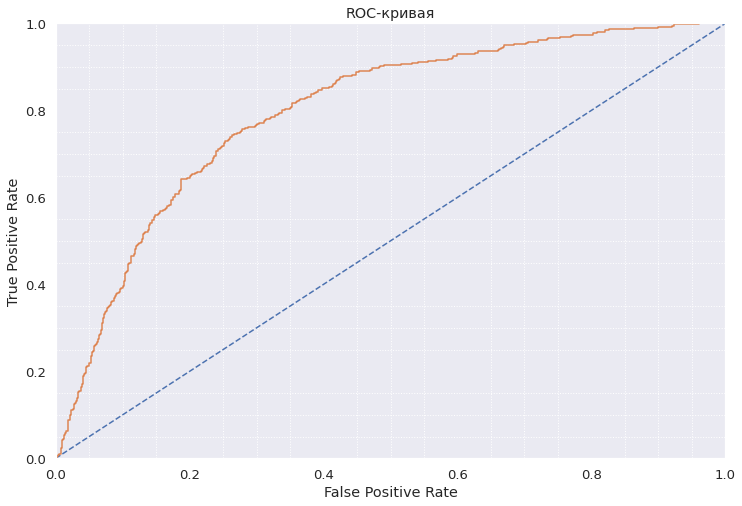

Площадь под ROC-кривой: 0.7964377648044143


In [93]:
plt.figure(figsize=(12,8))

plt.plot([0, 1], [0, 1], linestyle='--')

plt.step(fpr, tpr, where='post')

plt.minorticks_on()
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

print('Площадь под ROC-кривой:', roc_auc_score(y_valid, probabilities_one_valid))

Увеличилась F1-мера и точность, уменьшилась полнота. Площадь под ROC-кривой без динамики.

### **Изменение порога**

Изменим значения вероятности класса чтобы проверить влияние на метрики качества моделей.

#### *Решающее дерево*

In [94]:
model = DecisionTreeClassifier(random_state=12345, max_depth=best_depth_dtc)
model.fit(X_train, y_train)
probabilities_valid = model.predict_proba(X_valid)
probabilities_one_valid = probabilities_valid[:, 1]

f1_best = 0
best_predict = []
for threshold in tqdm(np.arange(0, 1.1, 0.02)):
    predicted_valid = probabilities_one_valid > threshold
    f1 = f1_score(y_valid, predicted_valid)
    if f1 > f1_best:
        f1_best = f1
        predicted_best = predicted_valid
        
print('F-1 мера:', f1_best)
print('Полнота:', recall_score(y_valid, predicted_best))
print('Точность:', precision_score(y_valid, predicted_best))

100%|██████████| 55/55 [00:00<00:00, 713.06it/s]

F-1 мера: 0.5954356846473029
Полнота: 0.7034313725490197
Точность: 0.5161870503597122


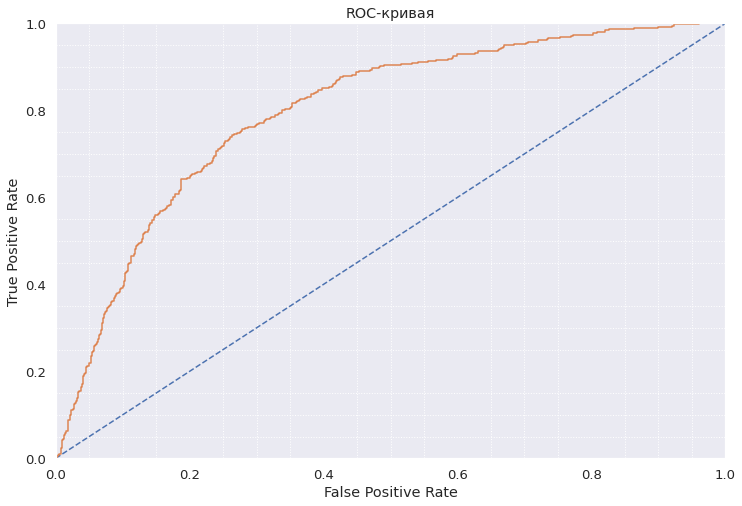

Площадь под ROC-кривой: 0.838121366637107


In [95]:
plt.figure(figsize=(12,8))

plt.plot([0, 1], [0, 1], linestyle='--')

plt.step(fpr, tpr, where='post')

plt.minorticks_on()
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

print('Площадь под ROC-кривой:', roc_auc_score(y_valid, probabilities_one_valid))

F1-мера и точность модели возросли, полнота снизилась, площадь под ROC-кривой уменьшилась.

#### *Случайный лес*

In [96]:
model = RandomForestClassifier(random_state=12345, max_depth=best_depth_rf, n_estimators=best_est_rf)
model.fit(X_train, y_train)
probabilities_valid = model.predict_proba(X_valid)
probabilities_one_valid = probabilities_valid[:, 1]

f1_best = 0
best_predict = []
best_threshold_a = 0
for threshold in tqdm(np.arange(0, 1.1, 0.02)):
    predicted_valid = probabilities_one_valid > threshold
    f1 = f1_score(y_valid, predicted_valid)
    if f1 > f1_best:
        f1_best = f1
        predicted_best = predicted_valid
        best_threshold_a = threshold
        
print('F-1 мера:', f1_best)
print('Полнота:', recall_score(y_valid, predicted_best))
print('Точность:', precision_score(y_valid, predicted_best))
print('Порог:', best_threshold_a)

100%|██████████| 55/55 [00:00<00:00, 715.97it/s]

F-1 мера: 0.6409937888198758
Полнота: 0.6323529411764706
Точность: 0.6498740554156172
Порог: 0.36


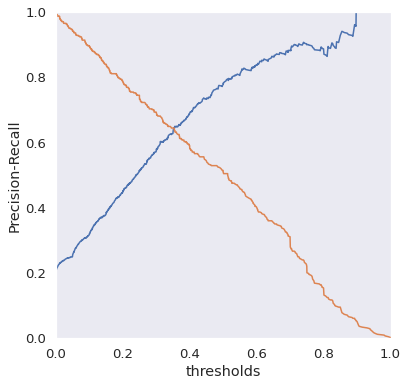

Best threshold = 0.354


In [97]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_valid, probabilities_one_valid)
plt.figure(figsize=(6, 6))
plt.plot(thresholds, precision[:-1])
plt.xlabel('thresholds')
plt.ylabel('Precision-Recall')
plt.plot(thresholds, recall[:-1])
plt.grid()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

print(f'Best threshold = {np.round(thresholds[np.argmin(np.abs(precision - recall))], 3)}')

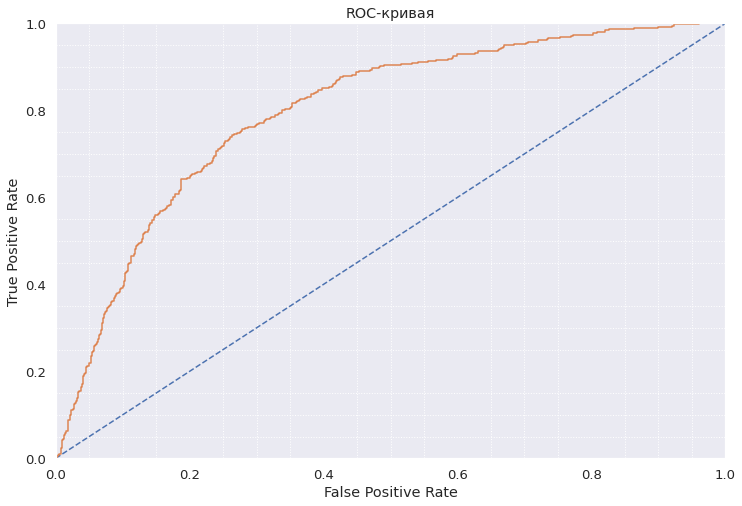

Площадь под ROC-кривой: 0.850627216967189


In [98]:
plt.figure(figsize=(12,8))

plt.plot([0, 1], [0, 1], linestyle='--')

plt.step(fpr, tpr, where='post')

plt.minorticks_on()
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

print('Площадь под ROC-кривой:', roc_auc_score(y_valid, probabilities_one_valid))

F1-мера и точность модели значительно возросли, при этом снизилась полнота. Площадь под ROC-кривой увеличилась

#### *Логистическая регрессия*

In [99]:
model = LogisticRegression(random_state=12345, max_iter=best_iterat_lr, solver='lbfgs')
model.fit(X_train, y_train)
probabilities_valid = model.predict_proba(X_valid)
probabilities_one_valid = probabilities_valid[:, 1]

f1_best = 0
best_predict = []
for threshold in tqdm(np.arange(0, 1.1, 0.02)):
    predicted_valid = probabilities_one_valid > threshold
    f1 = f1_score(y_valid, predicted_valid)
    if f1 > f1_best:
        f1_best = f1
        predicted_best = predicted_valid
        
print('F-1 мера:', f1_best)
print('Полнота:', recall_score(y_valid, predicted_best))
print('Точность:', precision_score(y_valid, predicted_best))

100%|██████████| 55/55 [00:00<00:00, 251.61it/s]

F-1 мера: 0.49948400412796706
Полнота: 0.5931372549019608
Точность: 0.43137254901960786


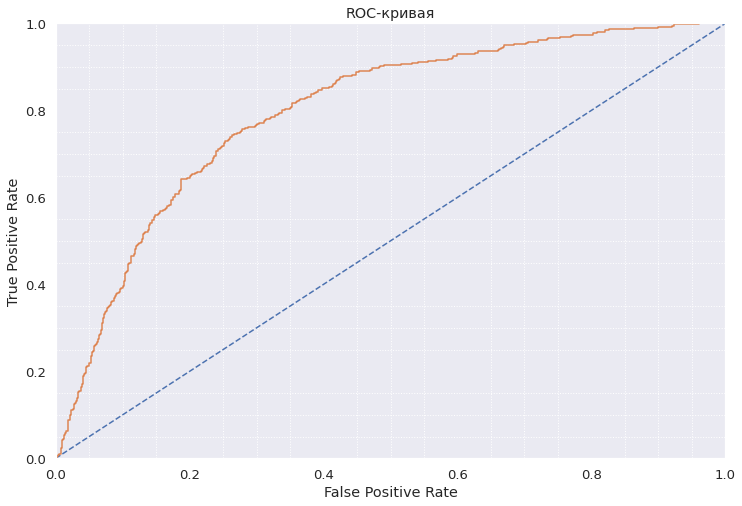

Площадь под ROC-кривой: 0.7674724726574046


In [100]:
plt.figure(figsize=(12,8))

plt.plot([0, 1], [0, 1], linestyle='--')

plt.step(fpr, tpr, where='post')

plt.minorticks_on()
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

print('Площадь под ROC-кривой:', roc_auc_score(y_valid, probabilities_one_valid))

У модели обученной методом логистической регрессии снизилась полнота, точность возросла, значение F1-меры незначительно снизилось, уменьшилась площадь под ROC-кривой.

### Проверка комбинированного способа борьбы с дисбалансом

Самые высокие значения F1-меры показала модель обученная методом *случайный лес* при обучении с увеличением выборки (F1-мера равная 0.62) и при изменении порога (F1-мера равная 0.64). Подберем оптимальные гиперпараметры для обучения модели на увеличенной выборке, а так же проведем подбор вероятности порога классификации. Обучив модель таким образом, проведем подсчет метрик качества модели, чтобы узнать возможно ли улучшить показатели модели.

In [101]:
best_depth_rf = 0
best_est_rf = 0
best_f1_rf = 0

for est in tqdm(range(10, 51, 10)):
    for depth in range(3, 20):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(X_upsampled, y_upsampled)
        predictions = model.predict(X_valid)
        f1_valid = f1_score(y_valid, predictions)
        if f1_valid > best_f1_rf:
            best_depth_rf = depth
            best_est_rf = est
            best_f1_rf = f1_valid
        
display(best_depth_rf)
display(best_est_rf)
display(best_f1_rf)

100%|██████████| 5/5 [00:18<00:00,  3.61s/it]


13

40

0.6574712643678161

In [102]:
model = RandomForestClassifier(random_state=12345, max_depth=best_depth_rf, n_estimators=best_est_rf)
model.fit(X_upsampled, y_upsampled)
probabilities_valid = model.predict_proba(X_valid)
probabilities_one_valid = probabilities_valid[:, 1]

f1_best = 0
predicted_best = []
best_threshold_f = 0

for threshold in tqdm(np.arange(0, 1.1, 0.02)):
    predicted_valid = probabilities_one_valid > threshold
    f1 = f1_score(y_valid, predicted_valid)
    if f1 > f1_best:
        f1_best = f1
        predicted_best = predicted_valid
        best_threshold_f = threshold
       
        
print('F-1 мера:', f1_best)
print('Полнота:', recall_score(y_valid, predicted_best))
print('Точность:', precision_score(y_valid, predicted_best))
print('Порог:', best_threshold_f)


100%|██████████| 55/55 [00:00<00:00, 765.65it/s]

F-1 мера: 0.6574712643678161
Полнота: 0.7009803921568627
Точность: 0.6190476190476191
Порог: 0.5


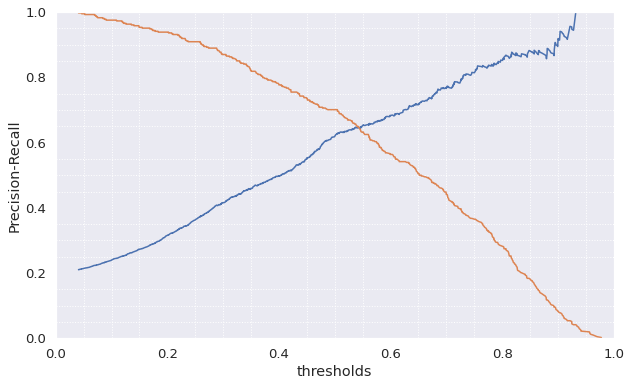

Best threshold = 0.543


In [103]:
precision, recall, thresholds = precision_recall_curve(y_valid, probabilities_one_valid)
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1])
plt.xlabel('thresholds')
plt.ylabel('Precision-Recall')
plt.plot(thresholds, recall[:-1])
plt.minorticks_on()
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

print(f'Best threshold = {np.round(thresholds[np.argmin(np.abs(precision - recall))], 3)}')

In [104]:
best_threshold = np.round(thresholds[np.argmin(np.abs(precision - recall))], 3)
print(best_threshold)

0.543


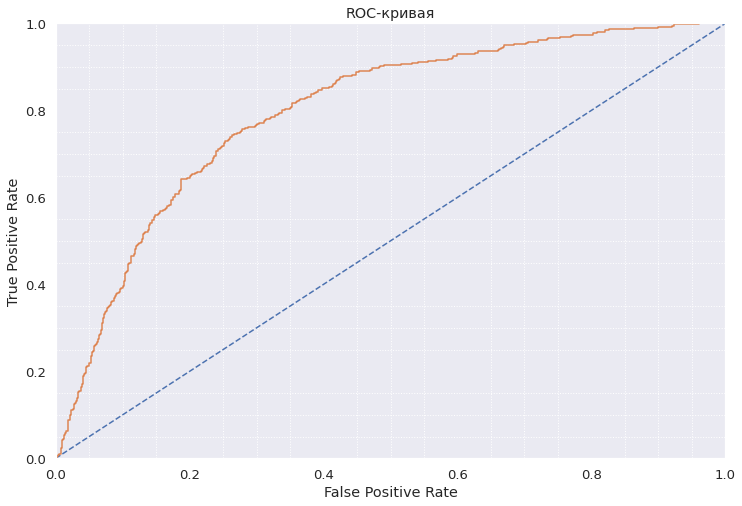

Площадь под ROC-кривой: 0.8681258621539067


In [105]:
plt.figure(figsize=(12,8))

plt.plot([0, 1], [0, 1], linestyle='--')

plt.step(fpr, tpr, where='post')

plt.minorticks_on()
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

print('Площадь под ROC-кривой:', roc_auc_score(y_valid, probabilities_one_valid))

Модель обученная комбинированным способом показывает результате ниже, чем модель *случайного леса* обученная с изменением значения вероятности класса. Уменьшились значения F1-меры, точности, площадь под ROC-кривой.

### Вывод

Наилучшее значение F1-меры при борьбе с дисбалансом классов, равное 0.64 продемонстрировала модель обученная методом случайного леса с изменением значения вероятности класса, второе по величине значение F1-меры показала модель случайного леса обученная на увеличенной выборке. Модель обученная комбинированным методом показала результат равный значению F1-меры 0.62. С учетом того, что все три показателя выше требуемого в исследовании значения 0.59, проведем тестирование модели сочетая два способа устранения дисбаланса.

## Тестирование модели

### Стандартизация данных

Для проведения тестирования обучим модель методом случайного леса с изменением порога (значения вероятности класса) на увеличенной выборке. Предварительно проведем стандартизацию тестовой выборки с помощью ранее обученного scaler.

In [106]:
X_test[numeric] = scaler.transform(X_test[numeric])

In [107]:
display(X_test)

,credit_score,age,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_France,geography_Germany,geography_Spain,...,tenure_1.0,tenure_2.0,tenure_3.0,tenure_4.0,tenure_5.0,tenure_6.0,tenure_7.0,tenure_8.0,tenure_9.0,tenure_10.0
657,-0.504497,1.429928,0.873883,2,1,1,1.725255,0,1,0,...,1,0,0,0,0,0,0,0,0,0
2083,-1.195031,-1.429769,-1.219673,1,1,1,1.203665,1,0,0,...,1,0,0,0,0,0,0,0,0,0
3234,-1.267176,0.762665,-1.219673,1,1,0,-1.374743,1,0,0,...,1,0,0,0,0,0,0,0,0,0
1551,0.825039,1.239281,-1.219673,2,0,1,0.382306,0,0,1,...,0,0,0,0,0,0,1,0,0,0
2344,0.660135,0.953312,0.267087,1,1,0,-1.613578,0,1,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5331,-0.133464,0.667342,1.072964,1,1,0,1.157484,0,1,0,...,0,1,0,0,0,0,0,0,0,0
4353,1.598025,-0.762506,-1.219673,2,1,0,-1.661784,1,0,0,...,0,0,0,1,0,0,0,0,0,0
5876,0.557070,0.000079,0.562103,1,1,0,1.722187,1,0,0,...,0,1,0,0,0,0,0,0,0,0
34,0.742587,-0.953153,-1.219673,2,1,1,0.723580,0,0,1,...,0,0,0,0,0,0,0,0,1,0


### Объединение выборок

Объединим тренировочную и валидационную выборку для обучения модели.

In [108]:
X_joined = pd.concat([X_train, X_valid])
y_joined = pd.concat([y_train, y_valid])

0    0.637
1    0.163
Name: exited, dtype: float64


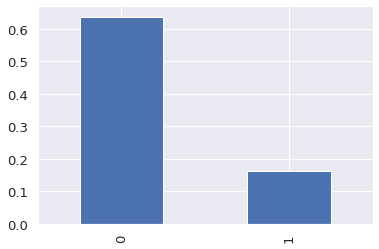

In [109]:
class_frequency = (y_joined.value_counts(normalize=False))/len(data)
print(class_frequency)
class_frequency.plot(kind='bar')
plt.show()

### Увеличение выборки и обучение модели

Исходя из частоты встречаемости класса увеличим выборку.

In [110]:
X_joined_up, y_joined_up = upsample(X_joined, y_joined, 4)

1    0.652
0    0.637
Name: exited, dtype: float64


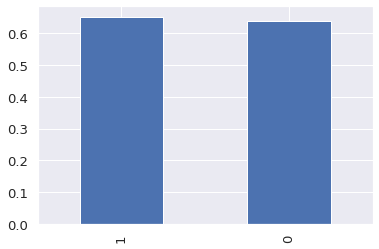

In [111]:
class_frequency = (y_joined_up.value_counts(normalize=False))/len(data)
print(class_frequency)
class_frequency.plot(kind='bar')
plt.show()

In [112]:
model = RandomForestClassifier(random_state=12345, max_depth=best_depth_rf, n_estimators=best_est_rf)
model.fit(X_joined_up, y_joined_up)
probabilities_valid = model.predict_proba(X_test)
probabilities_one_valid = (probabilities_valid[:, 1] > best_threshold_f)

        
print('F-1 мера:', f1_score(y_test, probabilities_one_valid))
print('Полнота:', recall_score(y_test, probabilities_one_valid))
print('Точность:', precision_score(y_test, probabilities_one_valid))

F-1 мера: 0.5920745920745922
Полнота: 0.6240786240786241
Точность: 0.5631929046563193


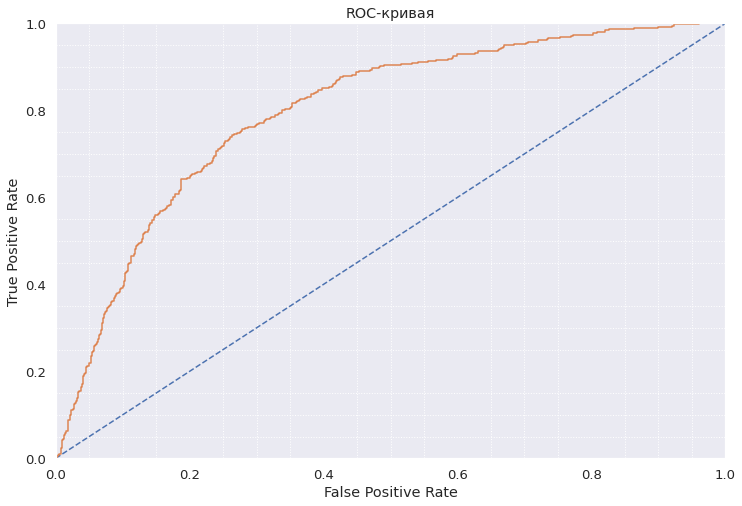

Площадь под ROC-кривой: 0.750206292579174


In [113]:
plt.figure(figsize=(12,8))

plt.plot([0, 1], [0, 1], linestyle='--')

plt.step(fpr, tpr, where='post')

plt.minorticks_on()
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

print('Площадь под ROC-кривой:', roc_auc_score(y_test, probabilities_one_valid))

### Вывод

Нами было проведено исследование обучения с учителями трех моделей, решающих задачи классификации с последующей оценкой качества моделей. В рамках исследования были проведенны исследовательский анализ и предобработка данных, включающие в себя:

- Проверку на явные и неявные дубликаты
- Проверку на наличие и обработку пропущенных значений
- Изучение корреляции признаков
- Удаление столбцов содержащих сведения неинформативные в рамках проводимого исследования

Так же была проведена подготовка признаков:
- Преобразование категориальных признаков в численные
- Определение целевого признака
- Отделение целового признака от прочих
- Разделение данных на три выборки - обучающую, валидационную и тестовую с использованием стратификации.
- Признаки имеющие большой разброс значений были стандартизированы с помощью StandartScaler

В рамках исследования были обучены модели:
- Решающее дерево, с подбором гиперпараметров
- Случайный лес, с подбором гиперпараметров
- Логистическая регрессия

Было установлено отсутсвие баланса классов в целевом признаке, при котором на не сбалансированных данных самое высокое значение F1-меры демонстировала модель обученная методом "случайный лес", самое низкое - логистической регрессии.
В целях улучшения качества моделей было проведено балансирование классов следующими методами:

**Взвешивание классов с результатами:**

*Решающее дерево*
- F-1 мера: 0.5693563009972801
- Полнота: 0.7696078431372549
- Точность: 0.45179856115107914
- Площадь под ROC-кривой: 0.8111898339737905

*Случайный лес*
- F-1 мера: 0.5570776255707763
- Полнота: 0.4485294117647059
- Точность: 0.7349397590361446
- Площадь под ROC-кривой: 0.8530497154892105

*Логистическая регрессия*
- F-1 мера: 0.5299295774647889
- Полнота: 0.7377450980392157
- Точность: 0.41346153846153844
- Площадь под ROC-кривой: 0.7937897206621343

**Увеличение выборки**

*Решающее дерево*
- F-1 мера: 0.5606326889279437
- Полнота: 0.7818627450980392
- Точность: 0.436986301369863
- Площадь под ROC-кривой: 0.7937897206621343

*Случайный лес*
- F-1 мера: 0.6015180265654649
- Полнота: 0.7769607843137255
- Точность: 0.4907120743034056
- Площадь под ROC-кривой: 0.8535816336584887

*Логистическая регрессия*
- F-1 мера: 0.5026656511805027
- Полнота: 0.8088235294117647
- Точность: 0.36464088397790057
- Площадь под ROC-кривой: 0.7942608261897725

**Уменьшение выборки**

*Решающее дерево*

- F-1 мера: 0.578512396694215
- Полнота: 0.7720588235294118
- Точность: 0.46255506607929514
- Площадь под ROC-кривой: 0.83213632500739

*Случайный лес*
- F-1 мера: 0.6015180265654649
- Полнота: 0.7769607843137255
- Точность: 0.4907120743034056
- Площадь под ROC-кривой: 0.8535816336584887

*Логистическая регрессия*

- F-1 мера: 0.5250431778929188
- Полнота: 0.7450980392156863
- Точность: 0.4053333333333333
- Площадь под ROC-кривой: 0.7924749359542811

**Изменение порога**

*Решающее дерево*
- F-1 мера: 0.6061997703788748
- Полнота: 0.6470588235294118
- Точность: 0.5701943844492441
- Площадь под ROC-кривой: 0.8279117708641246

*Случайный лес*
- F-1 мера: 0.6441136671177267
- Полнота: 0.5833333333333334
- Точность: 0.7190332326283988
- Площадь под ROC-кривой: 0.8610230995664598

*Логистическая регрессия*
- F-1 мера: 0.5244536940686785
- Полнота: 0.6176470588235294
- Точность: 0.45569620253164556
- Площадь под ROC-кривой: 0.7852143684106809

С опорой на полученные результаты можно сказать, что модели обученные методом логистической регрессии на всем протяжении исследования показывали самые низкие значения значения F1-меры и самые маленькие площади под ROC-кривой, что говорит о невысокой точности предсказания данного типа моделей при решении конкретной задачи, как на несбалансированных, так и на сбалансированных данных. 
Модели обученные методом решающего дерева показали промежуточные результаты, как на сбалансированных, так и на несбалансированных данных. 
Наиболее эффективными проявили себя модели обученные методом случайного леса. Модель обученная с изменением порога (значения класса) на валидационной выборке показала самое высокое значение F1-меры, равное 0,64 и самую большую плозадь под ROC-кривой, равную 0,86.

В результате исследования был выявлен комбинированный способ борьбы с дисбалансом классов основаный на увеличении выборки с одновременным изменением вероятности значения класса, модель обученная методом случайного леса на тестовых данных показала следующие результаты:

- F-1 мера: 0.6047032474804032
- Полнота: 0.6633906633906634
- Точность: 0.5555555555555556
- Площадь под ROC-кривой: 0.8403773573265099

Что удовлетворяет условиям исследования (значение F1-меры > 0,59).

Таким образом для решения задач классификации при условии дисбаланса классов рекомендуется обучение модели случайного леса с увеличением выборки и одновременным изменением вероятности значения класса с шагом 0.02.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*